# Campaign Response Model - Hyperparameter Tuning

Hyperparameter Tuning for XGBoost.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler, MOTPESampler

import plotly.express as px
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/train.csv"
test_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/test.csv"

train_df = pd.read_csv(train_url, index_col=0)
test_df = pd.read_csv(test_url, index_col=0)

X = train_df.copy() 
y = X.pop('response')
X_test = test_df.copy()
y_test = X_test.pop('response')

scale_pos_weight = (len(y) - sum(y)) / sum(y)
random_state = 61
cv = StratifiedKFold(5, shuffle=True, random_state=random_state)
# prep = Pipeline(steps=[('scaler', StandardScaler())])

In [4]:
features = ['recency','frequency_2y','monetary_2y','length_of_stay',
                'avg_spend_m_2y', 'avg_visit_m', 
                'avg_tte_2y', 'std_tte',  'cv_tte', 
                'std_ticket_size_2y', 'cv_ticket_size']
# features = ['recency','avg_tte_2y','avg_spend_m_2y','frequency_2y','monetary_2y', 'cv_ticket_size_1y']
X = X[features]
X_test = X_test[features]

# XGBoost Search

In [223]:
# Helper
def xgb_cv(X, y, params, cv, random_state=0):
    train_scores, val_scores = [],[]
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    return train_scores, val_scores

In [228]:
def objective(trial):
    params = {
        'max_depth' :trial.suggest_int('max_depth', 2, 5),
        'learning_rate' : trial.suggest_float('learning_rate', .01, .5, log=True),
        'subsample' : trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', .01, 100.0),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', .01, 100.0),
        'gamma' : trial.suggest_loguniform('gamma', .01, 100.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 20),
        # 'tree_method' : trial.suggest_categorical('tree_method', ['approx','exact','hist']),
        'tree_method' : 'approx',
        # fixed
        'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'scale_pos_weight' : scale_pos_weight,
        'random_state' : random_state,
        'nthread' : -1,
        'use_label_encoder' : False
    }

    train_scores, val_scores = xgb_cv(X, y, params, cv, random_state=random_state)
    trial.set_user_attr('val_std', np.std(val_scores))
    trial.set_user_attr('train_mean', np.mean(train_scores))
    trial.set_user_attr('train_std', np.std(train_scores))
    return np.mean(val_scores)

study1 = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
study1.optimize(objective, n_trials=500, show_progress_bar=True)
# study1 = optuna.create_study(directions=['maximize','maximize'], sampler=MOTPESampler(seed=random_state))
# study1.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-07-23 11:57:12,357] A new study created in memory with name: no-name-40cfbb95-7eeb-4183-bb79-b705d13952a5


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-07-23 11:57:12,766] Trial 0 finished with value: 0.7881715521350217 and parameters: {'max_depth': 5, 'learning_rate': 0.020328613356513564, 'subsample': 0.8895940913863473, 'colsample_bytree': 0.5495961766119754, 'colsample_bylevel': 0.9684337899004106, 'colsample_bynode': 0.10319099212875776, 'reg_alpha': 49.49683010310495, 'reg_lambda': 3.2943948695667395, 'gamma': 0.16488844410288392, 'min_child_weight': 7}. Best is trial 0 with value: 0.7881715521350217.
[I 2022-07-23 11:57:13,171] Trial 1 finished with value: 0.7964533087818609 and parameters: {'max_depth': 2, 'learning_rate': 0.06720497273535146, 'subsample': 0.8929420482203022, 'colsample_bytree': 0.5076955327834433, 'colsample_bylevel': 0.5274983620521739, 'colsample_bynode': 0.8941064781400013, 'reg_alpha': 4.675789886586051, 'reg_lambda': 0.021247852402317368, 'gamma': 0.012920927867508866, 'min_child_weight': 15}. Best is trial 1 with value: 0.7964533087818609.
[I 2022-07-23 11:57:13,383] Trial 2 finished with value:

## Explore parameter search results

In [229]:
t = study1.best_trial
print(f"Best Trial: {t.number}")
print(f"best value: {t.value},     val-std: {t.user_attrs['val_std']}")
print(f"train-mean: {t.user_attrs['train_mean']}, train-std: {t.user_attrs['train_std']}")
t.params

Best Trial: 295
best value: 0.803798067999686,     val-std: 0.014873830702521428
train-mean: 0.8183787722762466, train-std: 0.0054196151221515675


{'max_depth': 2,
 'learning_rate': 0.3052892973378435,
 'subsample': 0.904774690566026,
 'colsample_bytree': 0.8628777267625374,
 'colsample_bylevel': 0.9177121992719132,
 'colsample_bynode': 0.11510608947124179,
 'reg_alpha': 6.378828307258065,
 'reg_lambda': 23.37553281678809,
 'gamma': 0.15216206659591713,
 'min_child_weight': 10}

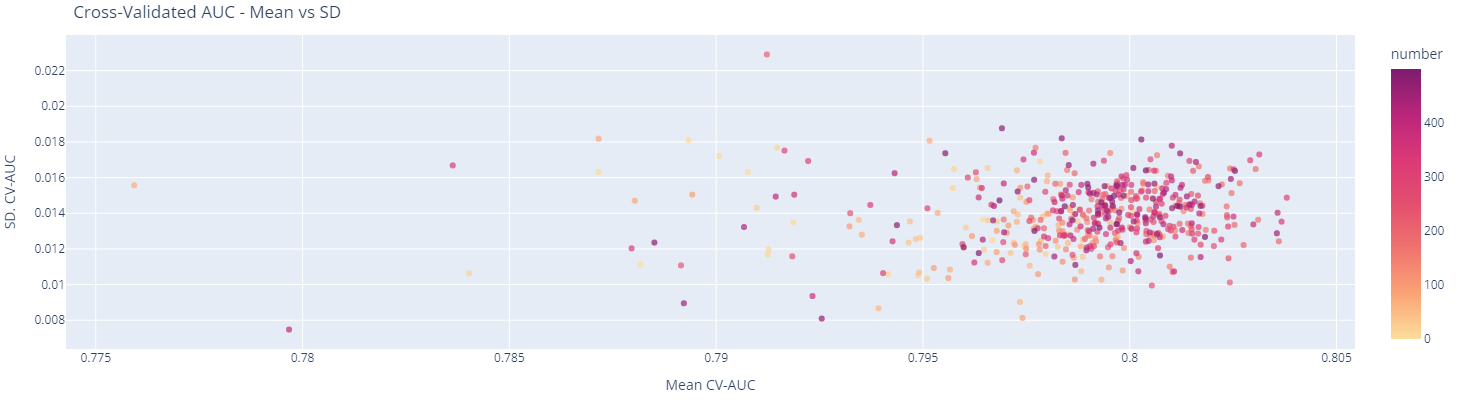

In [268]:
result = study1.trials_dataframe()
fig = px.scatter(result, x='value', y='user_attrs_val_std', hover_data=['number'], opacity=.7, 
                 color='number', color_continuous_scale=px.colors.sequential.Sunsetdark,
                 title='Cross-Validated AUC - Mean vs SD')
fig.update_layout(margin=dict(l=20, r=10, t=35, b=20), height=400, xaxis_title='Mean CV-AUC', yaxis_title='SD. CV-AUC')

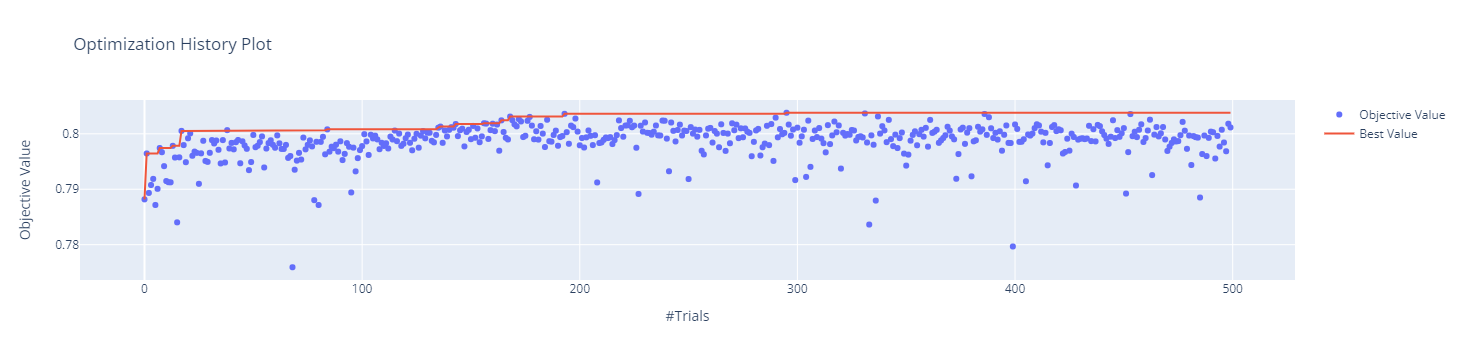

In [232]:
optuna.visualization.plot_optimization_history(study1)

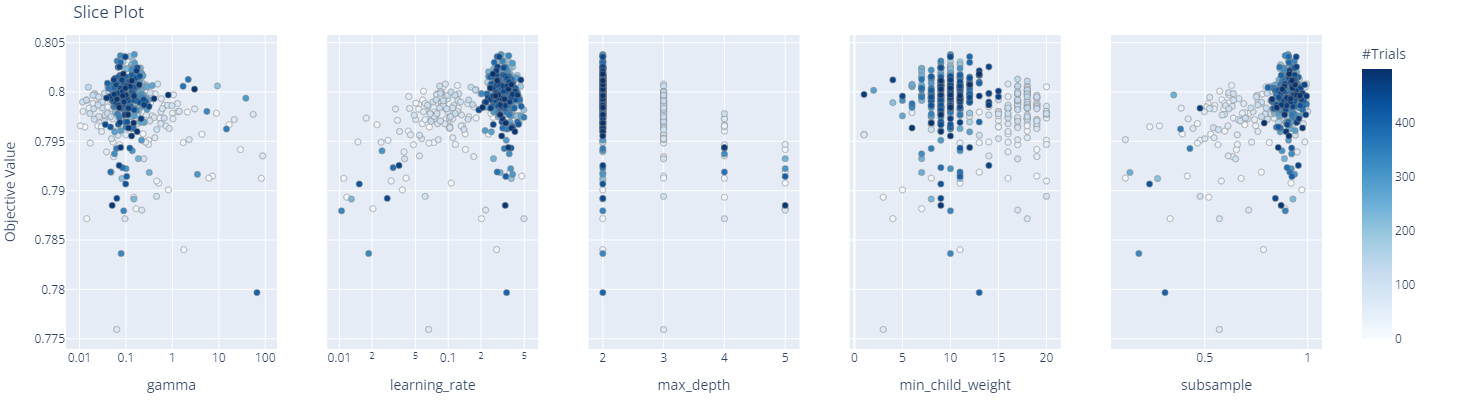

In [265]:
fig = optuna.visualization.plot_slice(study1, params=['max_depth','learning_rate','min_child_weight','subsample','gamma'])
fig.update_layout(margin=dict(l=20, r=10, t=35, b=20), height=400)

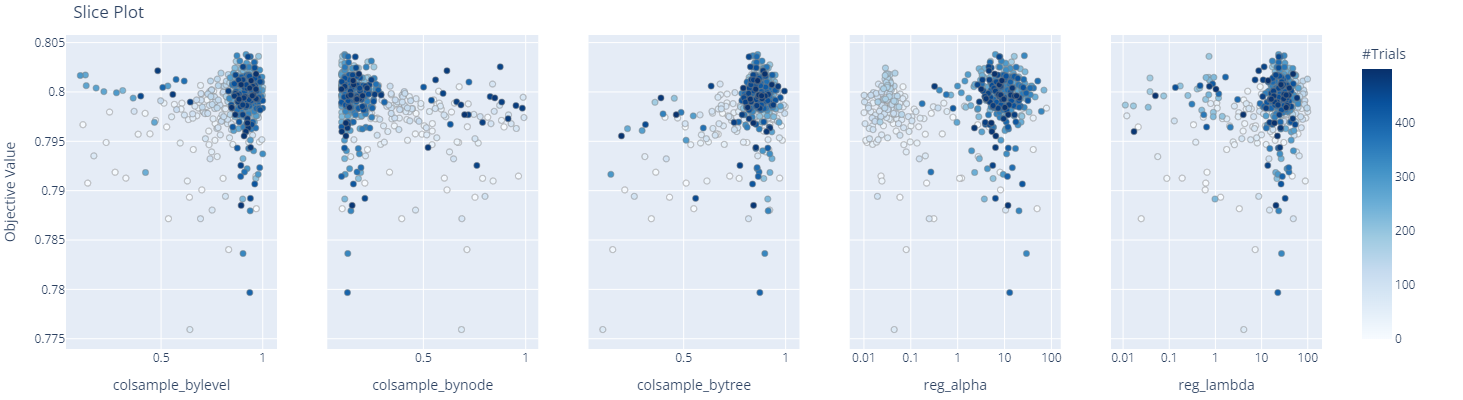

In [266]:
fig = optuna.visualization.plot_slice(study1, params=['colsample_bytree','colsample_bylevel','colsample_bynode','reg_alpha','reg_lambda'])
fig.update_layout(margin=dict(l=20, r=10, t=35, b=20), height=400, width=1500)

## Finding an appropriate number of estimators


100%|██████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


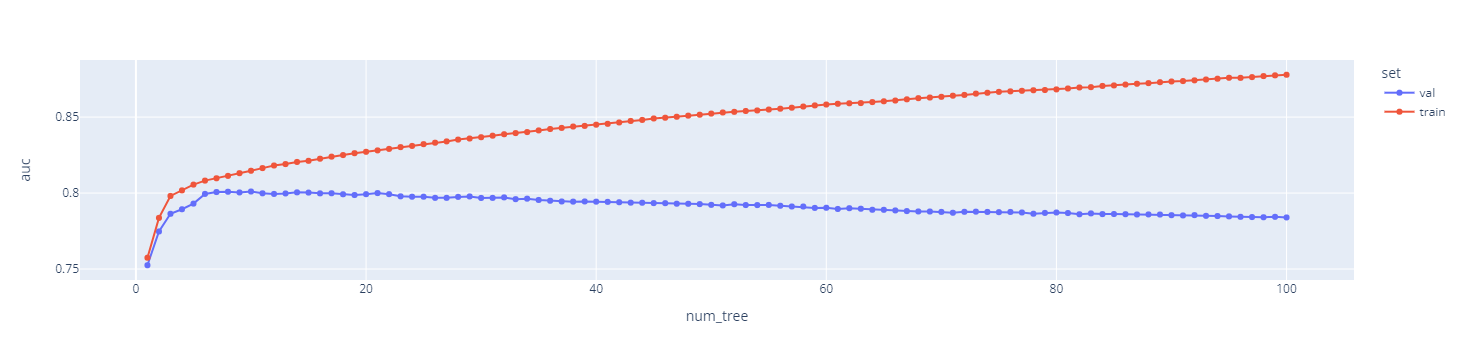

In [258]:
# best params
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'nthread' : -1,
    'scale_pos_weight' : scale_pos_weight,
    'random_state' : random_state,
    # tuned
    'tree_method' : 'approx',
    'max_depth': 2,
    'learning_rate': 0.3052892973378435,
    'subsample': 0.904774690566026,
    'colsample_bytree': 0.8628777267625374,
    'colsample_bylevel': 0.9177121992719132,
    'colsample_bynode': 0.11510608947124179,
    'reg_alpha': 6.378828307258065,
    'reg_lambda': 23.37553281678809,
    'gamma': 0.15216206659591713,
    'min_child_weight': 10
}

num_tree = np.arange(1,101)
train_cv_scores, val_cv_scores = [], []
x = []
for i in tqdm(num_tree):
    
    train_scores, val_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params, n_estimators=i)
        model.fit(X_train, y_train, verbose=False)
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    
    x.append(i)
    train_cv_scores.append(np.mean(train_scores))
    val_cv_scores.append(np.mean(val_scores))

df = pd.DataFrame({'num_tree': x, 'val' : val_cv_scores, 'train' : train_cv_scores})
df = df.melt('num_tree', var_name='set', value_name='auc')
fig = px.line(df, x='num_tree', y='auc', color='set', markers=True)
fig.show()

## Tuning Result

Train AUC: 0.8242759553643499
Test  AUC: 0.8104160455177897


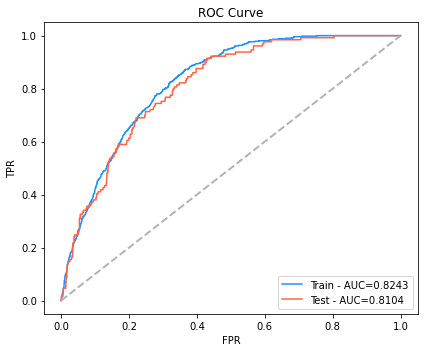

In [19]:
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'nthread' : -1,
    'scale_pos_weight' : scale_pos_weight,
    'random_state' : random_state,
    # tuned
    'tree_method' : 'approx',
    'max_depth': 2,
    'learning_rate': 0.3052892973378435,
    'subsample': 0.904774690566026,
    'colsample_bytree': 0.8628777267625374,
    'colsample_bylevel': 0.9177121992719132,
    'colsample_bynode': 0.11510608947124179,
    'reg_alpha': 6.378828307258065,
    'reg_lambda': 23.37553281678809,
    'gamma': 0.15216206659591713,
    'min_child_weight': 10,
    
    'n_estimators' : 20
}


clf = xgb.XGBClassifier(**params)
clf = clf.fit(X,y, verbose=False)

y_train_score = clf.predict_proba(X)[:,1]
y_test_score = clf.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y, y_train_score)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
auc_train = roc_auc_score(y, y_train_score)
auc_test = roc_auc_score(y_test, y_test_score)

print(f"Train AUC: {auc_train}")
print(f"Test  AUC: {auc_test}")

plt.figure(figsize=(6,5), tight_layout=True)
plt.plot(fpr_train, tpr_train, color='dodgerblue', label=f'Train - AUC={round(auc_train,4)}')
plt.plot(fpr_test, tpr_test, color='tomato', label=f'Test - AUC={round(auc_test,4)}')
plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()

In [272]:
import joblib
joblib.dump(clf, '../datasets/model.pkl')

['../datasets/model.pkl']

# LightGBM Search

In [5]:
def lgb_cv(X, y, params, cv, random_state=0):
    train_scores, val_scores = [],[]
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=0)
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    return train_scores, val_scores

In [ ]:
def objective(trial):

    params = {
        'objective' : 'binary',
        'is_unbalance' : 'true',
        'metric' : 'auc',
        'random_state' : random_state,
        'verbose' : 0,

        'learning_rate' : trial.suggest_float('learning_rate', .01, .5),
        'max_depth' : trial.suggest_int('max_depth', 2, 12),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 100),
        'min_gain_to_split' : trial.suggest_int('min_gain_to_split', 0, 15),
        'feature_fraction' : trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq' : trial.suggest_int('bagging_freq', 0, 15),

        'lambda_l1' : trial.suggest_loguniform('lambda_l1', 1e-3, 100.0),
        'lambda_l2' : trial.suggest_loguniform('lambda_l2', 1e-3, 100.0),
    
    }

    train_scores, val_scores = lgb_cv(X, y, params, cv, random_state=random_state)
    trial.set_user_attr('val_std', np.std(val_scores))
    trial.set_user_attr('train_mean', np.mean(train_scores))
    trial.set_user_attr('train_std', np.std(train_scores))
    return np.mean(val_scores)

lgb_study1 = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
lgb_study1.optimize(objective, n_trials=200, show_progress_bar=True)

In [7]:
t = lgb_study1.best_trial
print(f"Best Trial: {t.number}")
print(f"best value: {t.value},     val-std: {t.user_attrs['val_std']}")
print(f"train-mean: {t.user_attrs['train_mean']}, train-std: {t.user_attrs['train_std']}")
t.params

Best Trial: 133
best value: 0.8043343060734479,     val-std: 0.010184807329343043
train-mean: 0.8323762798124783, train-std: 0.016762041736059767


{'learning_rate': 0.06906777420765459,
 'max_depth': 12,
 'num_leaves': 62,
 'min_data_in_leaf': 96,
 'min_gain_to_split': 5,
 'feature_fraction': 0.9300072667527522,
 'bagging_fraction': 0.6095070163111674,
 'bagging_freq': 3,
 'lambda_l1': 0.006161068754354852,
 'lambda_l2': 4.83362258268529}

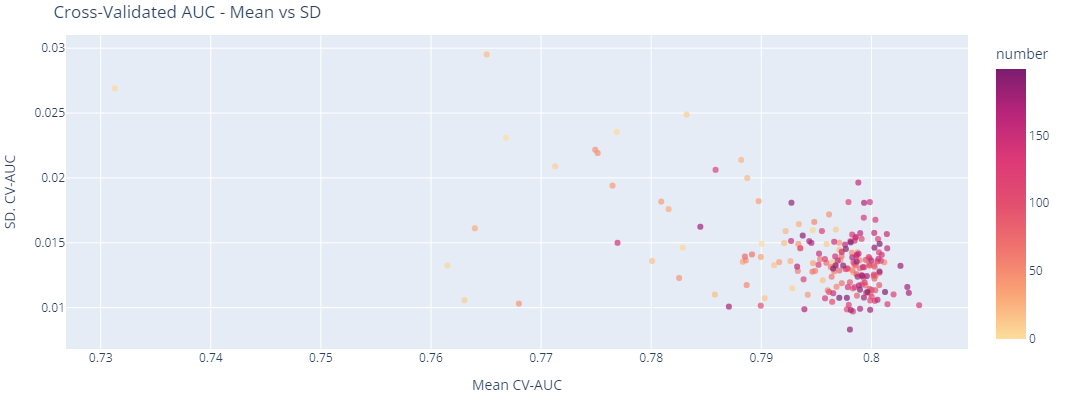

In [8]:
result = lgb_study1.trials_dataframe()
fig = px.scatter(result, x='value', y='user_attrs_val_std', hover_data=['number'], opacity=.7, 
                 color='number', color_continuous_scale=px.colors.sequential.Sunsetdark,
                 title='Cross-Validated AUC - Mean vs SD')
fig.update_layout(margin=dict(l=20, r=10, t=35, b=20), height=400, xaxis_title='Mean CV-AUC', yaxis_title='SD. CV-AUC')

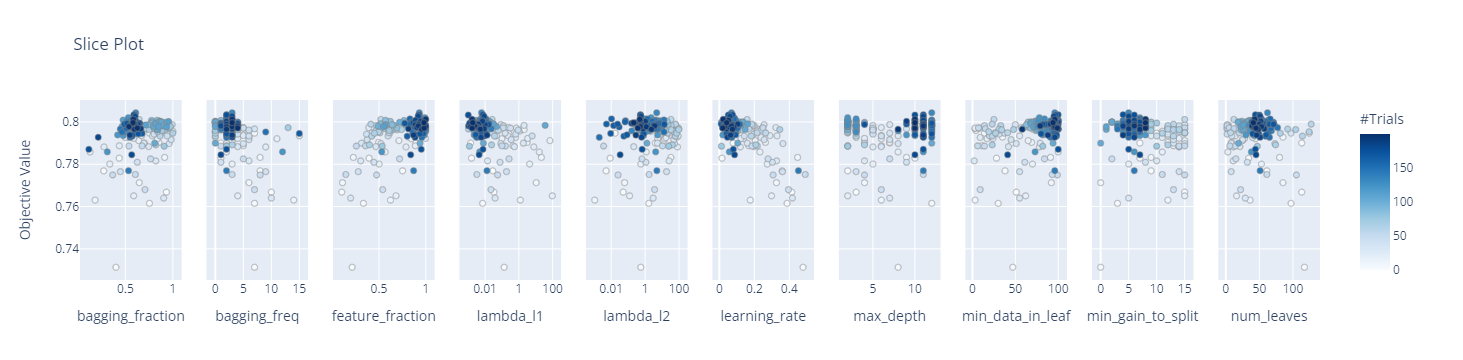

In [16]:
fig = optuna.visualization.plot_slice(lgb_study1)#, params=['max_depth','learning_rate','min_child_weight','subsample','gamma'])
fig.show()
# fig.update_layout(margin=dict(l=20, r=10, t=35, b=20), height=500)

[LightGBM] [Warning] feature_fraction is set=0.9300072667527522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9300072667527522
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=0.006161068754354852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006161068754354852
[LightGBM] [Warning] bagging_fraction is set=0.6095070163111674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6095070163111674
[LightGBM] [Warning] lambda_l2 is set=4.83362258268529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.83362258268529
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Train AUC: 0.8251655572762007
Test  AUC: 0.8069407175511827


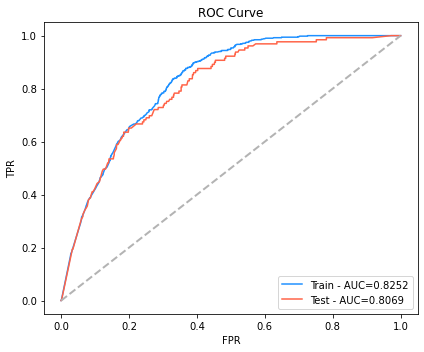

In [36]:
params = {
    'objective' : 'binary',
    'is_unbalance' : 'true',
    'metric' : 'auc',
    'random_state' : random_state,
    'verbose' : -1,

    'learning_rate': 0.06906777420765459,
    'max_depth': 12,
    'num_leaves': 62,
    'min_data_in_leaf': 96,
    'min_gain_to_split': 5,
    'feature_fraction': 0.9300072667527522,
    'bagging_fraction': 0.6095070163111674,
    'bagging_freq': 3,
    'lambda_l1': 0.006161068754354852,
    'lambda_l2': 4.83362258268529,
    'n_estimators' : 7
}


clf = lgb.LGBMClassifier(**params)
clf = clf.fit(X, y, verbose=-1)

y_train_score = clf.predict_proba(X)[:,1]
y_test_score = clf.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y, y_train_score)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
auc_train = roc_auc_score(y, y_train_score)
auc_test = roc_auc_score(y_test, y_test_score)

print(f"Train AUC: {auc_train}")
print(f"Test  AUC: {auc_test}")

plt.figure(figsize=(6,5), tight_layout=True)
plt.plot(fpr_train, tpr_train, color='dodgerblue', label=f'Train - AUC={round(auc_train,4)}')
plt.plot(fpr_test, tpr_test, color='tomato', label=f'Test - AUC={round(auc_test,4)}')
plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()